# Softmax Regression

Implementing Softmax function to classify MNIST data

## Display MNIST dataset

First of all, lets view some of the images in the dataset.

Two approaches of extracting images from "idx3-ubyte" file:
1. Using a library, idx2numpy, that wraps the code for extracting the data vector and simplifies the process.
2. Write the code yourself by using struct and matplotlib.

I will follow both approaches and write code for either one.

### Using idx2numpy library

In [ ]:
# import idx2numpy

# def load_mnist_images(file_path):
#     images = idx2numpy.convert_from_file(file_path)
#     return images

# def load_mnist_labels(file_path):
#     labels = idx2numpy.convert_from_file(file_path)
#     return labels

In [ ]:
# def get_images_using_idx2numpy(image_file, label_file):
#     """
#     Load MNIST images and labels using idx2numpy.
#     """
#     images = load_mnist_images(image_file)
#     labels = load_mnist_labels(label_file)

#     return images, labels

### Write code for extracting image data yourself

In [ ]:
import torch
import struct

def load_mnist_images_manual(image_path, label_path):
    with open (image_path, 'rb') as img_file:
        # Read the header
        magic, num_images, rows, cols = struct.unpack('>IIII', img_file.read(16))

        print(f"Magic: {magic}, Number of Images: {num_images}, Rows: {rows}, Columns: {cols}")

        # Read the image data
        image_data = img_file.read(rows * cols * num_images)
        images = torch.frombuffer(image_data, dtype=torch.uint8)

        images = images.reshape((num_images, rows, cols))

    with open (label_path, 'rb') as lbl_file:
        # Read the header
        magic, num_labels = struct.unpack('>II', lbl_file.read(8))

        print(f"Magic: {magic}, Number of Labels: {num_labels}")

        # Read the label data
        label_data = lbl_file.read(num_labels)
        labels = torch.frombuffer(label_data, dtype=torch.uint8)

    return images, labels

### Display Images using either approaches

In [ ]:
# Display some random images
import matplotlib.pyplot as plt
import math

def display_images(images, labels):
    cols = 4
    rows = math.ceil(len(images) / cols)
    plt.figure(figsize=(20, 10))
    index = 0

    for x in zip(images, labels):
        image = x[0]
        label = x[1]
        plt.subplot(rows, cols, index + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        index += 1

Magic: 2051, Number of Images: 60000, Rows: 28, Columns: 28
Magic: 2049, Number of Labels: 60000


<ipython-input-1-c67bd28fb593>:13: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:1561.)
  images = torch.frombuffer(image_data, dtype=torch.uint8)


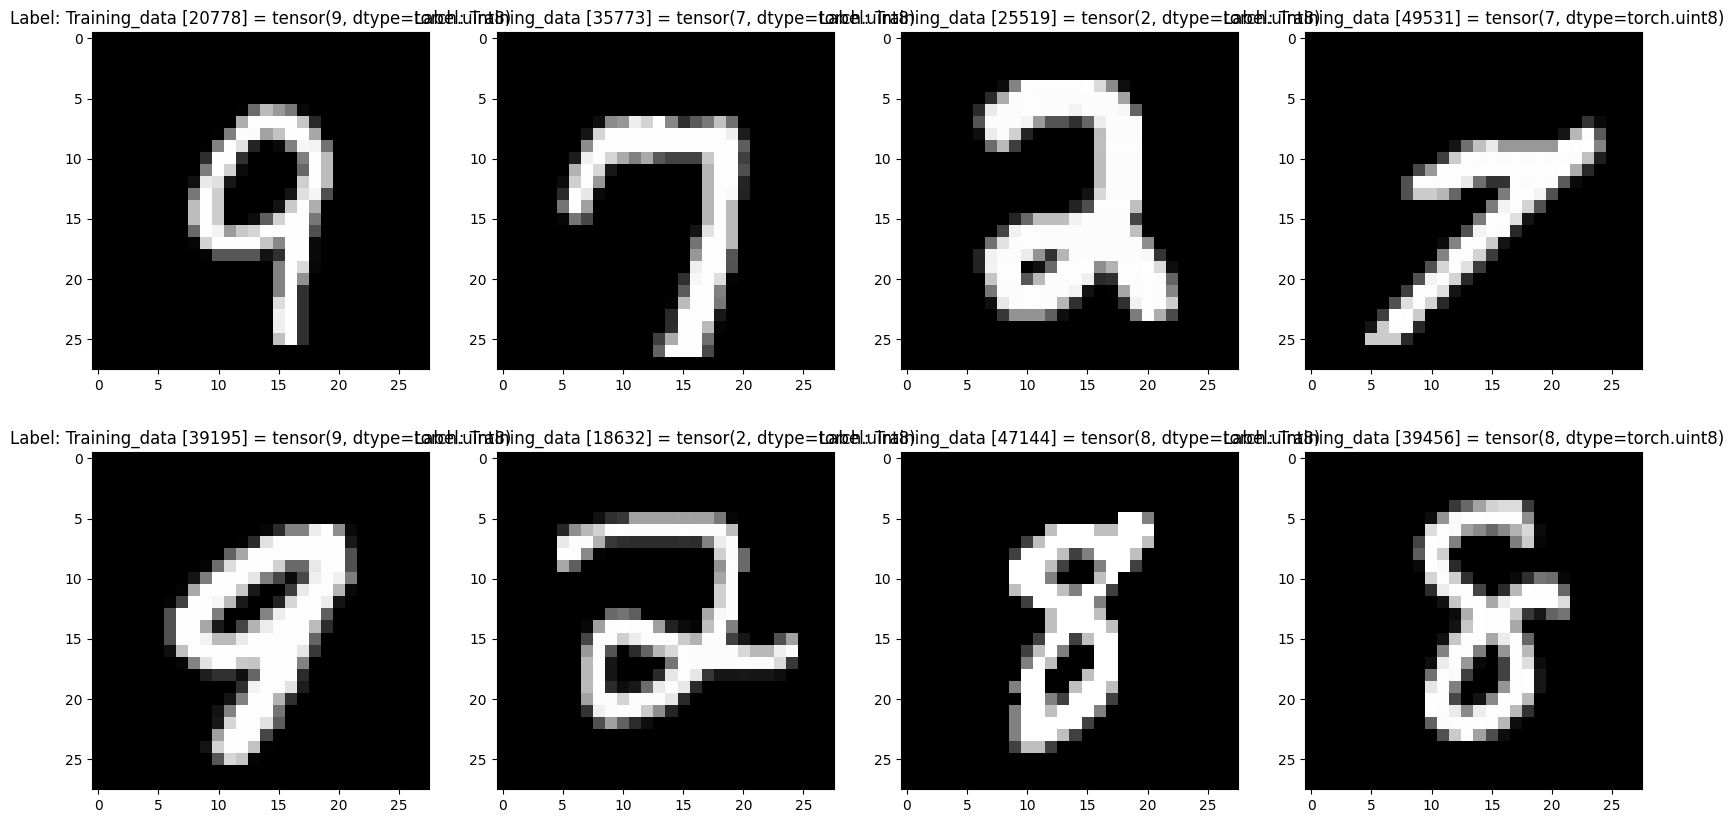

In [ ]:
import random

images_to_display = []
labels_to_display = []

# images, labels = get_images_using_idx2numpy(
#     "dataset/train-images.idx3-ubyte",
#     "dataset/train-labels.idx1-ubyte"
# )

images, labels = load_mnist_images_manual(
    "dataset/train-images.idx3-ubyte",
    "dataset/train-labels.idx1-ubyte"
)

for i in range(8):
    ran_idx = random.randint(0, labels.shape[0] - 1)
    images_to_display.append(images[ran_idx])
    labels_to_display.append("Training_data [" + str(ran_idx) + "] = " + str(labels[ran_idx]))



display_images(images_to_display, labels_to_display)

## Preprocessing of Data

Now, we have a numerical data of images as matrix representation. We perform pre-processings before classifying the data to one of the labels.
1. Flatten the images into 1D vector
2. Scale the pixel values to [0, 1]
3. Encode the labels

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


### Flatten the 2D images (28 * 28) to 1D vector

In [ ]:
X_train, y_train = load_mnist_images_manual(
    "dataset/train-images.idx3-ubyte",
    "dataset/train-labels.idx1-ubyte"
)

X_train = X_train.to(device)
y_train = y_train.to(device)

Magic: 2051, Number of Images: 60000, Rows: 28, Columns: 28
Magic: 2049, Number of Labels: 60000


In [ ]:
print(f"2D shape of X_train: {X_train.shape}")

2D shape of X_train: torch.Size([60000, 28, 28])


In [ ]:
# Reshape X_train to 1D array

X_train = X_train.reshape(X_train.shape[0], -1)
print(f"Reshaped X_train to 1D array: {X_train.shape}")

Reshaped X_train to 1D array: torch.Size([60000, 784])


### Scale the pixel values to [0, 1]

Each pixel value can range from [0, 255]. The pixel values are scaled to be in the range of [0, 1].
We perform scaling using Min-Max Scaling:

$$
x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}
$$

Here,

$$
x_{scaled} = \frac{x}{255}
$$

In [ ]:
X_train = X_train.float() / 255.0

### Encode the labels

The labels range is [0, 9]. We will encode the label into one-hot labels.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

In [ ]:
# Reshape y_train to match the shape of training data

y_train = y_train.reshape(-1, 1)

In [ ]:
y_train = encoder.fit_transform(y_train.to("cpu"))

In [ ]:
y_train = torch.tensor(y_train.toarray(), dtype=torch.float32).to(device)

## Define initial parameters

In [ ]:
alpha = 0.0001

input_size = X_train.shape[1]
num_classes = y_train.shape[1]

input_layer = input_size
hidden_layer = 128
output_layer = num_classes

W1 = torch.rand(hidden_layer, input_layer, dtype=torch.float32).to(device)
b1 = torch.zeros(hidden_layer, dtype=torch.float32).to(device)

W2 = torch.rand(output_layer, hidden_layer, dtype=torch.float32).to(device)
b2 = torch.zeros(output_layer, dtype=torch.float32).to(device)

# theta = torch.rand(num_classes, input_size, dtype=torch.float32).to(device)
# bias = torch.zeros(num_classes, dtype=torch.float32).to(device)

# print(f"Initial theta shape: {theta.shape}")
# print(f"Initial bias shape: {bias.shape}")

## Training of model

For multi-class classification, we implement softmax regression (multinominal logistic regression) using softmax function.

In [ ]:
def relu(x):
  return torch.maximum(x, torch.tensor(0.0))

In [ ]:
def softmax_function(z):
    # The value of z can be large and exp(z) can output inf or nan. To prevent this, we can stabilize the value of z.
    z = z - torch.max(z, dim=1, keepdim=True)[0]
    exp_z = torch.exp(z)

    y_pred = exp_z / torch.sum(exp_z, dim=1, keepdim=True)

    return y_pred

In [ ]:
def forward_pass(X, W1, b1, W2, b2):
    z1 = X @ W1.T + b1
    y_hidden = relu(z1)

    z2 = y_hidden @ W2.T + b2
    y_pred = softmax_function(z2.reshape(-1, num_classes))
    return y_pred, y_hidden

In [ ]:
def predict(X, W1, b1, W2, b2):
    y_pred, _ = forward_pass(X, W1, b1, W2, b2)
    return torch.argmax(y_pred)

### Loss Function

Cross entropy (or log loss) is the loss function being used in this softmax regression. It compares the predicted probability distribution against the real distribution and computes the loss.

In [ ]:
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-9  # To avoid log(0)
    y_pred_clamped = torch.clamp(y_pred, epsilon, 1.0)

    loss = - torch.sum(y_true * torch.log(y_pred_clamped))

    return loss

In [ ]:
def gradient_descent(X, y_true, y_hidden, y_pred):
    global alpha, W1, b1, W2, b2

    dz2 = y_pred - y_true
    # dj_d_theta = torch.matmul(dz.reshape(-1, 1), X.reshape(1, -1))
    # dj_db = dz
    dj_d_W2 = dz2.T @ y_hidden
    dj_db2 = torch.sum(dz2, dim=0)

    dz1 = dz2 @ W2
    dz1[y_hidden <= 0] = 0
    dj_d_W1 = dz1.T @ X
    dj_db1 = torch.sum(dz1, dim=0)


    W2 -= alpha * dj_d_W2
    b2 -= alpha * dj_db2
    W1 -= alpha * dj_d_W1
    b1 -= alpha * dj_db1

In [ ]:
epochs = 100

batch_size = 64
num_of_samples = X_train.shape[0]

for epoch in range(epochs):
    total_loss = 0
    iteration = 0

    perm = torch.randperm(num_of_samples)
    X_train_shuffled = X_train[perm]
    y_train_shuffled = y_train[perm]

    for i in range(0, num_of_samples, batch_size):
        X_train_batch = X_train_shuffled[i : i + batch_size]
        y_train_batch = y_train_shuffled[i : i + batch_size]

        # Forward pass to get prediction
        y_pred, y_hidden = forward_pass(X_train_batch, W1, b1, W2, b2)

        y_true = y_train_batch

        # Calculate loss
        loss = cross_entropy_loss(y_true, y_pred)
        total_loss += loss

        # Perform gradient descent
        gradient_descent(X_train_batch, y_true, y_hidden, y_pred)

        # print(f"Iteration {iteration + 1}")
        iteration += 1

    # Print loss at every epochs
    print(f"Epoch {epoch + 1}\nLoss: {total_loss / X_train.shape[0]}")

Epoch 1
Loss: 12.954120635986328
Epoch 2
Loss: 4.885222911834717
Epoch 3
Loss: 3.488495111465454
Epoch 4
Loss: 3.0339300632476807
Epoch 5
Loss: 2.7361502647399902
Epoch 6
Loss: 2.682931900024414
Epoch 7
Loss: 2.584567070007324
Epoch 8
Loss: 2.4212446212768555
Epoch 9
Loss: 2.4279661178588867
Epoch 10
Loss: 2.3530123233795166
Epoch 11
Loss: 2.303727388381958
Epoch 12
Loss: 2.2566890716552734
Epoch 13
Loss: 2.2505786418914795
Epoch 14
Loss: 2.1057395935058594
Epoch 15
Loss: 2.0986826419830322
Epoch 16
Loss: 2.1588528156280518
Epoch 17
Loss: 2.0006015300750732
Epoch 18
Loss: 2.01548433303833
Epoch 19
Loss: 1.9632009267807007
Epoch 20
Loss: 1.966604232788086
Epoch 21
Loss: 1.9497952461242676
Epoch 22
Loss: 1.8709282875061035
Epoch 23
Loss: 1.8944928646087646
Epoch 24
Loss: 1.8280527591705322
Epoch 25
Loss: 1.9016644954681396
Epoch 26
Loss: 1.8467752933502197
Epoch 27
Loss: 1.7937555313110352
Epoch 28
Loss: 1.797903299331665
Epoch 29
Loss: 1.7406800985336304
Epoch 30
Loss: 1.732489228248596

## Test the model

In [ ]:
X_test, y_test = load_mnist_images_manual(
    "dataset/t10k-images.idx3-ubyte",
    "dataset/t10k-labels.idx1-ubyte"
)

Magic: 2051, Number of Images: 10000, Rows: 28, Columns: 28
Magic: 2049, Number of Labels: 10000


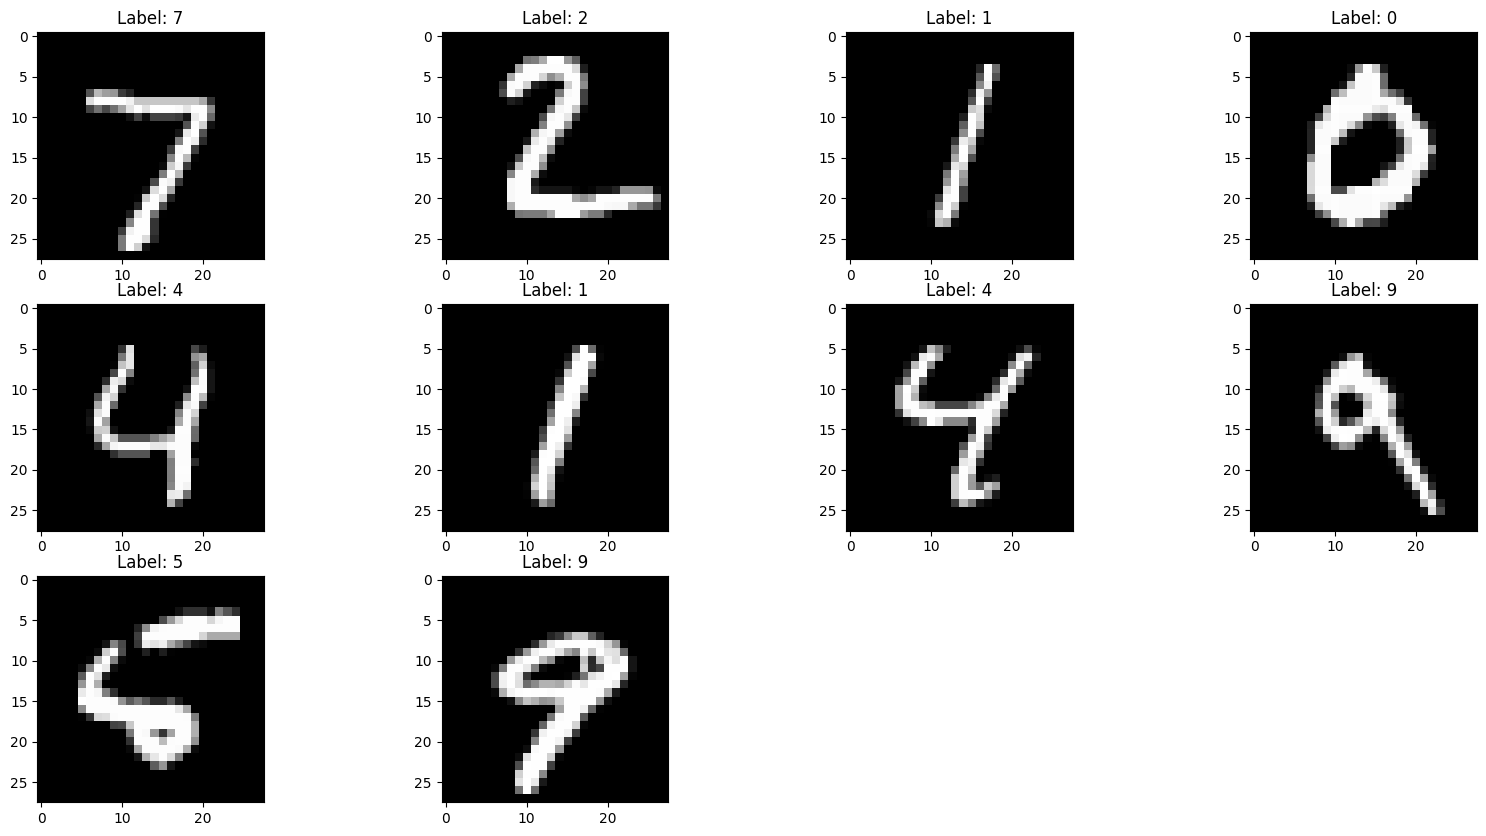

In [ ]:
display_images(X_test[:10], y_test[:10])

In [ ]:
# Reshape X_test to 1D array
X_test = X_test.reshape(X_test.shape[0], -1)

# Scale the test data
X_test = X_test.float() / 255.0

X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

# Encode Label
y_test = encoder.transform(y_test.reshape(-1, 1).to("cpu"))

y_test = torch.tensor(y_test.toarray(), dtype=torch.float32).to(device)

<ipython-input-24-4dca1454caad>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)


In [ ]:
correct = 0

for i in range(len(X_test)):
    X = X_test[i]
    y_pred = predict(X, W1, b1, W2, b2)
    print(f"Actual: {y_test[i].argmax()}, Predicted: {y_pred}")
    if y_pred == torch.argmax(y_test[i]):
        correct += 1

accuracy = (correct / len(X_test)) * 100
print(f"Accuracy on test set: {accuracy:.2f}%")

Streaming output truncated to the last 5000 lines.
Actual: 9, Predicted: 8
Actual: 9, Predicted: 9
Actual: 8, Predicted: 8
Actual: 4, Predicted: 4
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 6, Predicted: 6
Actual: 0, Predicted: 0
Actual: 9, Predicted: 4
Actual: 6, Predicted: 6
Actual: 8, Predicted: 8
Actual: 6, Predicted: 6
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 9, Predicted: 4
Actual: 8, Predicted: 8
Actual: 9, Predicted: 4
Actual: 2, Predicted: 2
Actual: 3, Predicted: 3
Actual: 5, Predicted: 5
Actual: 5, Predicted: 5
Actual: 9, Predicted: 9
Actual: 4, Predicted: 4
Actual: 2, Predicted: 2
Actual: 1, Predicted: 1
Actual: 9, Predicted: 9
Actual: 4, Predicted: 4
Actual: 3, Predicted: 3
Actual: 9, Predicted: 9
Actual: 6, Predicted: 6
Actual: 0, Predicted: 0
Actual: 4, Predicted: 4
Actual: 0, Predicted: 0
Actual: 6, Predicted: 6
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 2, Predicted: 2
Actual: 3, Predicted: 2
Actual: 4, Predicted: 4
Actual: 7, Pr